In [ ]:
!pip install tensorflow==2.11.0

In [ ]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os
import joblib

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
import torch
from transformers import AlbertTokenizer, TFAlbertModel
from torch.utils.data import DataLoader, TensorDataset

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

GPU is NOT available


In [ ]:
try:
    # TPU detection
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # GPU detection
    if tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy()
        print('Running on multiple GPUs')
    else:
        # Default distribution strategy in TensorFlow. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()
        print('Running on CPU or single GPU')

print('Number of replicas:', strategy.num_replicas_in_sync)


Running on CPU or single GPU
Number of replicas: 1


In [ ]:
MODEL_NAME = 'roberta_base'
MAX_LEN = 64
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 128
EPOCHS = 5

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_df = pd.read_csv("labeled_data.csv")

In [ ]:
# df1=df[df['class']==0]
# df2=df[df['class']==1]
# df3=df[df['class']==2]

In [ ]:
# df4=df2.sample(df1.shape[0])
# df4.shape

In [ ]:
# df5=df3.sample(df1.shape[0])
# df5.shape

In [ ]:
# train_df=pd.concat([df1,df4,df5])
# train_df.shape

In [ ]:
train_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
train_df['tweet'].value_counts()

tweet
!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...          1
RT @MurderHigashi: I cannot be worried 'bout no bitch.                                                                                                1
RT @MrPerfect_22: Most of these niggas go broke for these hoes !!                                                                                     1
RT @MrPOONsoaker: Foh RT @Thotcho: @MrPOONsoaker lmao 6&#8242;0 but I&#8217;m hella skinny so bitches don&#8217;t like me                             1
RT @MrNationWide: fake eyelashes are okay if they look natural, but some of you bitches look like you gonna take flight if you blink too fa&#8230;    1
                                                                                                                                                     ..
But she can shade the shit out a bitch RT @axolROSE: #YourWifeCantRead            

In [ ]:
train_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
# text processing function

import re
import string
def clean_text(text):
    # to lower case
    text = text.lower()
    # remove links
    text = re.sub('https:\/\/\S+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'@\w+', '', text)
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # remove next line
    text = re.sub(r'[^ \w\.]', '', text)
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)

    return text
# Create a new column called "Text" for collecting clean text
train_df['Text'] = train_df.tweet.apply(lambda x: clean_text(x))

In [ ]:
X_data = train_df[['Text']].to_numpy().reshape(-1)
y_data = train_df[['class']].to_numpy().reshape(-1)

In [ ]:
train_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,Text
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,rt as a woman you shouldnt complain about cl...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dats coldtyga dwn bad for cuffin dat ...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt you ever fuck a bitch and she st...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt the shit you hear about me might be true ...


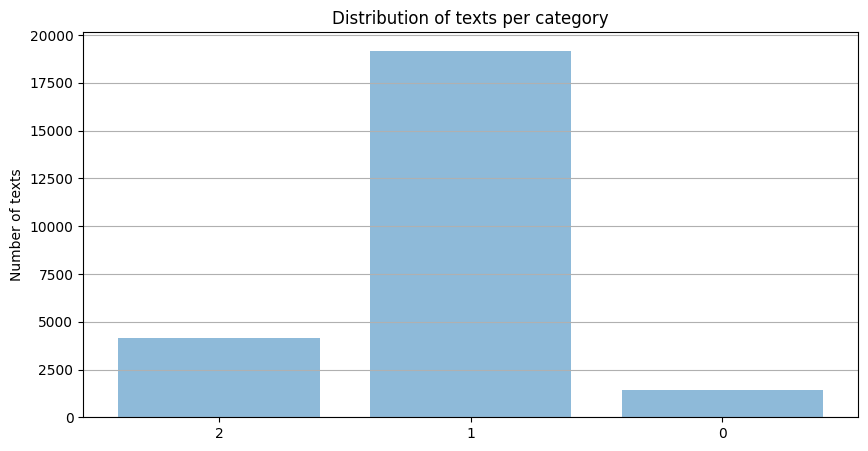

Counter({1: 19190, 2: 4163, 0: 1430})


In [ ]:
categories = train_df[['class']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [ ]:
def calculate_stats(train_df, split_char=' '):
    categories = train_df['class'].unique()

    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in train_df.iterrows():
        text = row['Text']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)

        category = row['class']

        all_lengths.append(l)
        per_category['lengths'][category].append(l)

    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])

    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }

    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = train_df['class'].unique()
    n_rows = math.ceil(len(categories) / n_cols)

    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')

    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)

        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In [ ]:
df_stats = calculate_stats(train_df)
df_stats['per_category']

,lengths,mean,stdev
2,"[24, 10, 7, 6, 12, 13, 8, 12, 16, 16, 13, 18, ...",13.752342,6.556480
1,"[14, 19, 7, 25, 19, 19, 13, 13, 5, 17, 8, 11, ...",13.138562,6.552611
0,"[3, 12, 11, 14, 8, 20, 20, 6, 10, 17, 12, 7, 2...",13.106294,6.824494


In [ ]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = train_df['class'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 24783
Number of categories: 3
Done!


In [ ]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)

        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])

        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN

        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')

        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777)

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained('albert-large-v2')

In [ ]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [ ]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import albert model from HuggingFace
        model = TFAlbertModel.from_pretrained("albert-large-v2")
        x = model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position

        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [ ]:
strategy = tf.distribute.get_strategy()

In [ ]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 64)]         0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 tf_albert_model (TFAlbertModel  TFBaseModelOutputWi  17683968   ['input_word_ids[0][0]',         
 )                              thPooling(last_hidd               'input_mask[0][0]',         

In [ ]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/5


136/136 [==============================] - 9192s 68s/step - loss: 0.7107 - accuracy: 0.7678 - val_loss: 0.6824 - val_accuracy: 0.7693
Epoch 2/5
136/136 [==============================] - 9399s 69s/step - loss: 0.6120 - accuracy: 0.7777 - val_loss: 0.5814 - val_accuracy: 0.7801
Epoch 3/5
136/136 [==============================] - 11934s 88s/step - loss: 0.5249 - accuracy: 0.8061 - val_loss: 0.5125 - val_accuracy: 0.8116
Epoch 4/5
136/136 [==============================] - 13104s 97s/step - loss: 0.4590 - accuracy: 0.8352 - val_loss: 0.4700 - val_accuracy: 0.8234
Epoch 5/5
136/136 [==============================] - 13409s 98s/step - loss: 0.4171 - accuracy: 0.8526 - val_loss: 0.4220 - val_accuracy: 0.8486


In [ ]:
model_filename = 'Albert_large_davidson.pkl'
joblib.dump(model, model_filename)
print("Model saved as:", model_filename)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......flatten
.........vars
......input_layer
.........vars
......input_layer_1
.........vars
......input_layer_2
.........vars
......tf_albert_model
.........albert
............embeddings
...............LayerNorm
..................vars
.....................0
.....................1
...............dropout
..................vars
...............vars
..................0
..................1
..................2
............encoder
...............albert_layer_groups
..................tf_albert_layer_group
.....................albert_layers
........................tf_albert_layer
...........................attention
..............................LayerNorm
.................................vars
....................................0
....................................1
................

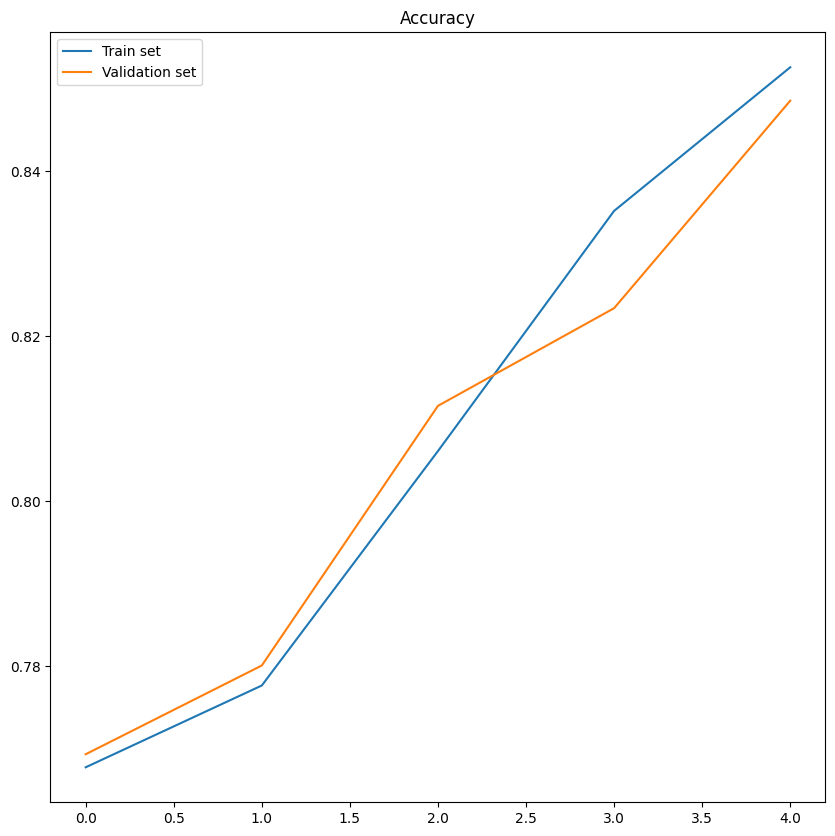

In [ ]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

In [ ]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names,
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 84.86%


In [ ]:
plot_confusion_matrix(X_test, y_test, model)